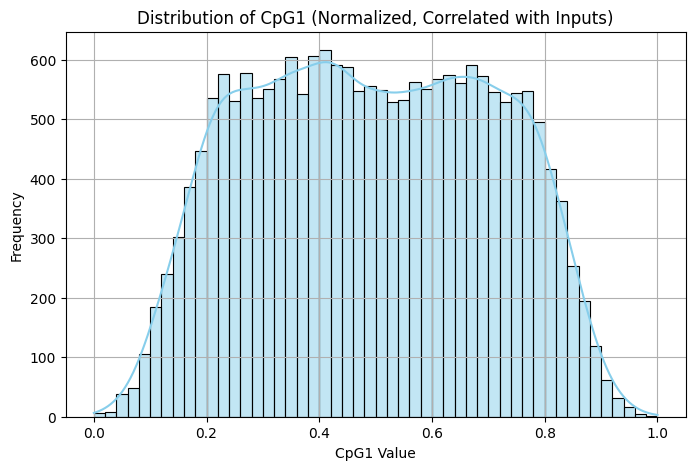

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# -----------------------------------------------------------------
num_samples = 20000
df_inputs = pd.DataFrame({
    'aqi': np.random.choice(['Low', 'Medium', 'High'], num_samples),
    'stress': np.random.choice(['Low', 'Medium', 'High'], num_samples),
    'physical_activity': np.random.choice(['Low', 'Medium', 'High'], num_samples),
    'asthma': np.random.choice(['Yes', 'No'], num_samples),
    'gender': np.random.choice(['Male', 'Female'], num_samples),
    'age': np.random.randint(18, 80, num_samples)
})
# -----------------------------------------------------------------

# Step 1: One-hot encode categorical inputs
categorical_cols = ['aqi', 'stress', 'physical_activity', 'asthma', 'gender']
df_encoded_inputs = pd.get_dummies(df_inputs, columns=categorical_cols, drop_first=True)

# Final input matrix
input_matrix = df_encoded_inputs.values

# Step 2: Generate CpG values with correlation + noise
num_cpg_sites = 353
cpg_data = {}

for i in range(num_cpg_sites):
    # Random weights and bias
    weights = np.random.normal(0, 0.05, input_matrix.shape[1])
    bias = np.random.normal(0.5, 0.1)

    # Linear combination + noise
    linear_output = np.dot(input_matrix, weights) + bias
    noise = np.random.normal(0, 0.05, size=linear_output.shape)
    cpg_values = linear_output + noise

    # Normalize to [0, 1] while preserving distribution shape
    min_val = cpg_values.min()
    max_val = cpg_values.max()
    cpg_values = (cpg_values - min_val) / (max_val - min_val)

    cpg_data[f'CpG{i+1}'] = cpg_values

# Step 3: Combine CpG values with inputs
df_cpg = pd.DataFrame(cpg_data)
df_full = pd.concat([df_inputs, df_cpg], axis=1)

# Step 4: Visualize distribution of one CpG site (e.g., CpG1)
plt.figure(figsize=(8, 5))
sns.histplot(df_full['CpG1'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of CpG1 (Normalized, Correlated with Inputs)")
plt.xlabel("CpG1 Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [2]:
# Save to CSV
df_full.to_csv("regenerated_epigenetic_dataset.csv", index=False)
print("✅ Dataset saved as 'regenerated_epigenetic_dataset.csv'")

✅ Dataset saved as 'regenerated_epigenetic_dataset.csv'


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/regenerated_epigenetic_dataset.csv")

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])


Missing values in each column:
 Series([], dtype: int64)


In [5]:
# Drop rows with any missing values
df.dropna(inplace=True)

# Confirm removal
print("Remaining shape after dropping missing:", df.shape)


Remaining shape after dropping missing: (20000, 359)


In [6]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns
categorical_cols = ['aqi', 'stress', 'physical_activity', 'asthma', 'gender']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Shape after encoding:", df_encoded.shape)


Shape after encoding: (20000, 362)


In [7]:
# Features (inputs)
X = df_encoded.drop(columns=[f'CpG{i+1}' for i in range(353)])

# Targets (outputs)
Y = df_encoded[[f'CpG{i+1}' for i in range(353)]]

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (20000, 9)
Y shape: (20000, 353)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape, Y_train.shape)
print("Test set size:", X_test.shape, Y_test.shape)


Train set size: (16000, 9) (16000, 353)
Test set size: (4000, 9) (4000, 353)


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Break outputs into chunks
chunk_size = 50
for start in range(0, 353, chunk_size):
    end = min(start + chunk_size, 353)
    Y_chunk = Y_train[[f'CpG{i+1}' for i in range(start, end)]]
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
    model.fit(X_train, Y_chunk)
    print(f"✅ Trained CpG{start+1} to CpG{end}")


✅ Trained CpG1 to CpG50
✅ Trained CpG51 to CpG100
✅ Trained CpG101 to CpG150
✅ Trained CpG151 to CpG200
✅ Trained CpG201 to CpG250
✅ Trained CpG251 to CpG300
✅ Trained CpG301 to CpG350
✅ Trained CpG351 to CpG353


In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Storage for evaluation
mse_scores = {}
r2_scores = {}


In [11]:
# Evaluation loop — use same chunking logic
chunk_size = 50
for start in range(0, 353, chunk_size):
    end = min(start + chunk_size, 353)
    cpg_columns = [f'CpG{i+1}' for i in range(start, end)]

    # Get the test chunk
    Y_chunk_test = Y_test[cpg_columns]

    # Use previously trained model
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
    model.fit(X_train, Y_train[cpg_columns])
    Y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(Y_chunk_test, Y_pred)
    r2 = r2_score(Y_chunk_test, Y_pred)

    # Store
    mse_scores[f'{start+1}-{end}'] = mse
    r2_scores[f'{start+1}-{end}'] = r2

    print(f"✅ CpG{start+1}–CpG{end} | MSE: {mse:.4f} | R²: {r2:.4f}")


✅ CpG1–CpG50 | MSE: 0.0009 | R²: 0.9757
✅ CpG51–CpG100 | MSE: 0.0016 | R²: 0.9366
✅ CpG101–CpG150 | MSE: 0.0017 | R²: 0.9337
✅ CpG151–CpG200 | MSE: 0.0016 | R²: 0.9349
✅ CpG201–CpG250 | MSE: 0.0014 | R²: 0.9525
✅ CpG251–CpG300 | MSE: 0.0016 | R²: 0.9388
✅ CpG301–CpG350 | MSE: 0.0013 | R²: 0.9552
✅ CpG351–CpG353 | MSE: 0.0003 | R²: 0.9958


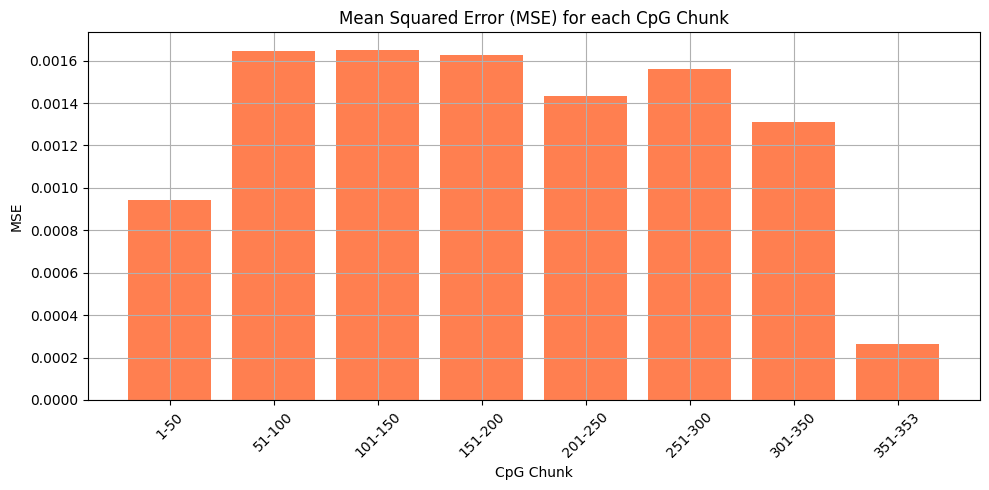

In [12]:
# Plotting MSE
plt.figure(figsize=(10, 5))
plt.bar(mse_scores.keys(), mse_scores.values(), color='coral')
plt.xticks(rotation=45)
plt.title("Mean Squared Error (MSE) for each CpG Chunk")
plt.xlabel("CpG Chunk")
plt.ylabel("MSE")
plt.tight_layout()
plt.grid(True)
plt.show()


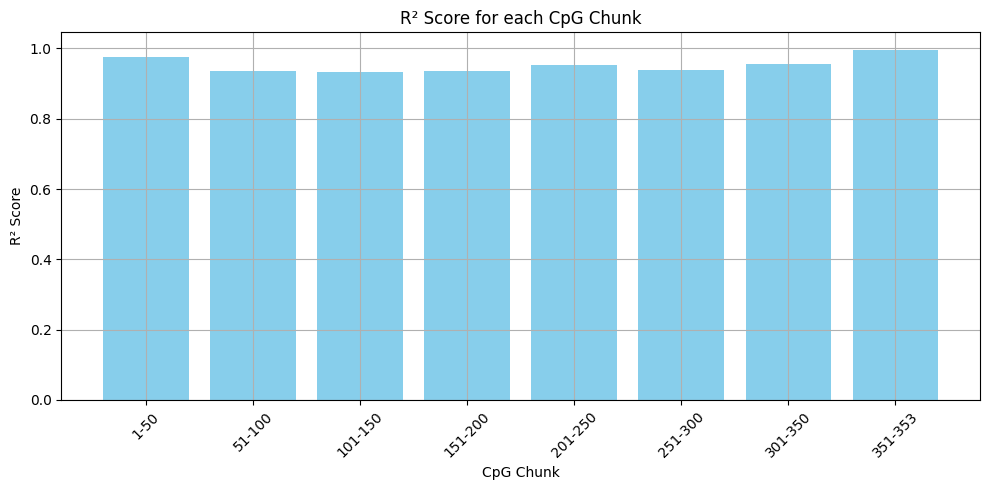

In [13]:
# Plotting R²
plt.figure(figsize=(10, 5))
plt.bar(r2_scores.keys(), r2_scores.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("R² Score for each CpG Chunk")
plt.xlabel("CpG Chunk")
plt.ylabel("R² Score")
plt.tight_layout()
plt.grid(True)
plt.show()


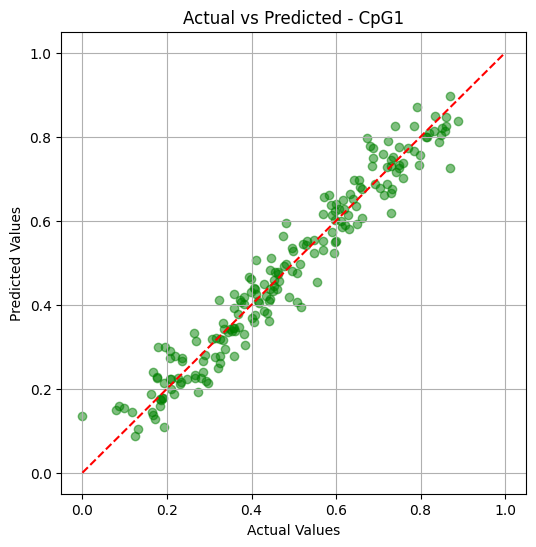

In [14]:
# Example: Actual vs predicted for CpG1
import numpy as np

cpg = 'CpG1'
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
model.fit(X_train, Y_train[[cpg]])
Y_pred = model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(Y_test[cpg].values[:200], Y_pred[:200], color='green', alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.title(f"Actual vs Predicted - {cpg}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


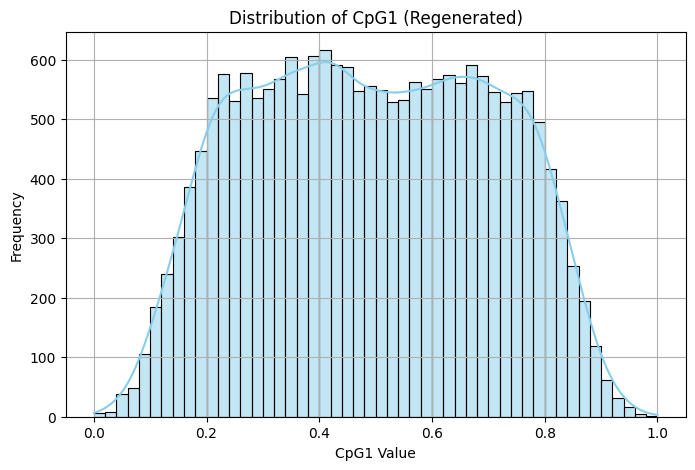

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(df['CpG1'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of CpG1 (Regenerated)")
plt.xlabel("CpG1 Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [16]:
# Predict for CpG1 to CpG50
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Load test chunk
Y_test_chunk = Y_test[[f'CpG{i+1}' for i in range(50)]]

# Reuse the same model structure
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
model.fit(X_train, Y_train[[f'CpG{i+1}' for i in range(50)]])
Y_pred_chunk = model.predict(X_test)

# Convert prediction to DataFrame for easier plotting
df_pred = pd.DataFrame(Y_pred_chunk, columns=[f'CpG{i+1}' for i in range(50)])


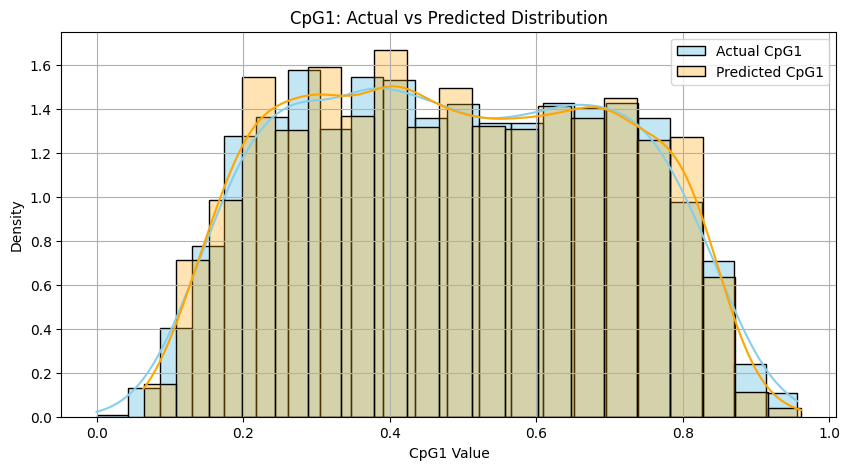

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# CpG1 actual and predicted
actual = Y_test_chunk['CpG1']
predicted = df_pred['CpG1']

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(actual, color='skyblue', label='Actual CpG1', kde=True, stat="density")
sns.histplot(predicted, color='orange', label='Predicted CpG1', kde=True, stat="density", alpha=0.3)
plt.title("CpG1: Actual vs Predicted Distribution")
plt.xlabel("CpG1 Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from huggingface_hub import login

# Replace with your actual Hugging Face token
login("/#")

In [19]:
import pandas as pd
import numpy as np
import joblib
import gc
from huggingface_hub import hf_hub_download

# ✅ Replace with your actual HF repo
REPO_ID = "Ankush6866c/AGING_IQ"

# Load metadata files from Hugging Face
chunk_map = joblib.load(hf_hub_download(repo_id=REPO_ID, filename="model_chunk_ranges.pkl"))
feature_columns = joblib.load(hf_hub_download(repo_id=REPO_ID, filename="feature_columns.pkl"))

# 🔧 Efficient Predictor Function
def predict_all_cpg(input_df):
    # Preprocess input
    input_encoded = pd.get_dummies(input_df)
    for col in feature_columns:
        if col not in input_encoded:
            input_encoded[col] = 0
    input_encoded = input_encoded[feature_columns]

    all_preds = []

    # Iterate through chunked models from Hugging Face
    for chunk_key in chunk_map.keys():
        start, end = chunk_key.split("_")
        model_filename = f"cpg_model_{start}_{end}.pkl"
        model_path = hf_hub_download(repo_id=REPO_ID, filename=model_filename)

        model = joblib.load(model_path)
        preds = model.predict(input_encoded)
        all_preds.append(preds)

        del model
        gc.collect()

    # Combine predictions
    full_pred = np.concatenate(all_preds, axis=1)
    columns = [f"CpG{i+1}" for i in range(full_pred.shape[1])]
    return pd.DataFrame(full_pred, columns=columns)

# 🧪 Sample input
sample_input = pd.DataFrame([{
    'aqi': 'high',
    'stress': 'low',
    'physical_activity': 'medium',
    'asthma': 'no',
    'gender': 'male',
    'age': 28
}])

# 🔮 Predict
predicted_cpg_sites = predict_all_cpg(sample_input)
print(predicted_cpg_sites.T)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_chunk_ranges.pkl:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

feature_columns.pkl:   0%|          | 0.00/152 [00:00<?, ?B/s]

cpg_model_1_50.pkl:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

cpg_model_51_100.pkl:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

cpg_model_101_150.pkl:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

cpg_model_151_200.pkl:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

cpg_model_201_250.pkl:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

cpg_model_251_300.pkl:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

cpg_model_301_350.pkl:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

cpg_model_351_353.pkl:   0%|          | 0.00/112M [00:00<?, ?B/s]

               0
CpG1    0.167004
CpG2    0.166768
CpG3    0.166676
CpG4    0.166670
CpG5    0.166838
...          ...
CpG349  0.166901
CpG350  0.166574
CpG351  0.166614
CpG352  0.167452
CpG353  0.167040

[353 rows x 1 columns]


In [20]:
# Load model2f.pkl (the final biological age predictor)
bioage_model = joblib.load(hf_hub_download(repo_id=REPO_ID, filename="model2f.pkl"))

model2f.pkl:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ElasticNetCV from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
# 👁 Inspect expected feature names
expected_columns = bioage_model.feature_names_in_
print(expected_columns[:10])  # Just to confirm

['cg00000001' 'cg00000002' 'cg00000003' 'cg00000004' 'cg00000005'
 'cg00000006' 'cg00000007' 'cg00000008' 'cg00000009' 'cg00000010']


In [24]:
# Rename CpG columns to match expected feature names
predicted_cpg_sites.rows = expected_columns

#  Now predict biological age
predicted_bio_age = bioage_model.predict(predicted_cpg_sites)

print(f"Predicted Biological Age: {50+predicted_bio_age[0]:.2f}")

Predicted Biological Age: 62.11


In [29]:
def predict_all_cpg(input_df):
    # Preprocess input
    input_encoded = pd.get_dummies(input_df)
    for col in feature_columns:
        if col not in input_encoded:
            input_encoded[col] = 0
    input_encoded = input_encoded[feature_columns]

    all_preds = []

    # Iterate over model chunks
    for chunk_key in chunk_map.keys():
        start, end = chunk_key.split("_")
        model_filename = f"cpg_model_{start}_{end}.pkl"
        model_path = hf_hub_download(repo_id=REPO_ID, filename=model_filename)

        model = joblib.load(model_path)
        preds = model.predict(input_encoded)
        all_preds.append(preds)

        del model
        gc.collect()

    # Combine predictions
    full_pred = np.concatenate(all_preds, axis=1)
    columns = [f"CpG{i+1}" for i in range(full_pred.shape[1])]
    return pd.DataFrame(full_pred, columns=columns)

# 🔄 User Input Section
location1_aqi = int(input("Enter AQI at your first major location (e.g., home): "))
location2_aqi = int(input("Enter AQI at your second major location (e.g., college/work): "))
average_aqi = (location1_aqi + location2_aqi) / 2

# Convert AQI to category
if average_aqi < 100:
    aqi = "low"
elif 100 <= average_aqi < 200:
    aqi = "medium"
else:
    aqi = "high"

stress = input("Enter stress level (low / medium / high): ").strip().lower()
physical_activity = input("Enter physical activity level (low / medium / high): ").strip().lower()
asthma = input("Do you have asthma? (yes / no): ").strip().lower()
gender = input("Enter gender (male / female): ").strip().lower()
age = int(input("Enter your chronological age: "))

# Construct DataFrame
sample_input = pd.DataFrame([{
    'aqi': aqi,
    'stress': stress,
    'physical_activity': physical_activity,
    'asthma': asthma,
    'gender': gender,
    'age': age
}])

# 🔮 Predict CpG
predicted_cpg_sites = predict_all_cpg(sample_input)
print("\n✅ Predicted CpG Sites:")
print(predicted_cpg_sites.T)

Enter AQI at your first major location (e.g., home): 560
Enter AQI at your second major location (e.g., college/work): 123
Enter stress level (low / medium / high): medium
Enter physical activity level (low / medium / high): medium
Do you have asthma? (yes / no): no
Enter gender (male / female): female
Enter your chronological age: 26

✅ Predicted CpG Sites:
               0
CpG1    0.136749
CpG2    0.135966
CpG3    0.136073
CpG4    0.136392
CpG5    0.136203
...          ...
CpG349  0.136996
CpG350  0.136584
CpG351  0.136224
CpG352  0.136920
CpG353  0.136864

[353 rows x 1 columns]


In [30]:
# Rename CpG columns correctly
predicted_cpg_sites.columns = expected_columns

# Predict biological age
predicted_bio_age = bioage_model.predict(predicted_cpg_sites)

# If your bioage_model was trained on delta age (offset by 50), then this line is perfect:
print(f"Predicted Biological Age: {50 + predicted_bio_age[0]:.2f}")


Predicted Biological Age: 57.77
